# Imports and Folder settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import tifffile

import trackpy as tp
import pims

import glob # for tif folder function
import json

import time
import os

from scipy.spatial import cKDTree

from tqdm import tqdm

In [2]:
sim_name = "test_1"
output_dir = os.path.join("results", sim_name)

# Simulation section

In [3]:
import simulation_v3 as simulation

In [4]:
# set parameters
temperature=298.15            # Room temperature
viscosity=1.0e-3              # Water viscosity
mean_particle_radius=50e-9    # 50 nm radius (100 nm diameter) 
std_particle_radius=10e-9     # 10 nm std dev (~20 nm for diameter)
frame_size=(512, 512)        # Frame size
pixel_size=100e-9,             # Pixel size (100 nm)
z_range=(-10e-6, 10e-6)      # -10 to 10 micrometers in z
focal_plane=0.0               # Focal plane at z=0
depth_of_field=2e-6           # 2 micrometer depth of field
diffusion_time=0.1            # Time between frames
num_particles=100             # Number of particles
gaussian_sigma=1.0           # Base sigma for Gaussian
brightness_factor=1.0        # Brightness scaling factor
snr_base=5.0                  # Base SNR for smallest particle
snr_scaling=2.0               # SNR scaling with size
background_noise_alpha= 2.0    
background_noise_beta = 0.02
do_background_noise = True
noise_floor=50.0              # Baseline noise floor (in 16-bit scale)
noise_ceiling=2500.0          # Maximum expected pixel value (in 16-bit scale)


simulation.main(temperature, viscosity, mean_particle_radius, std_particle_radius, frame_size, pixel_size, z_range, focal_plane, 
         depth_of_field, diffusion_time, num_particles, gaussian_sigma, brightness_factor, snr_base, snr_scaling, 
         background_noise_alpha, background_noise_beta, noise_floor, noise_ceiling, sim_name)



Saved size distribution plot to results\test_1\size_distribution.png
Generating 3D simulation with focal plane effects...


Generating Frames:   5%|███▏                                                           | 5/100 [00:00<00:02, 46.42it/s]


Frame Pixel Statistics (0-1 scale):
  Min: 0.006174
  Max: 0.600418
  Mean: 0.040953
  0th percentile: 0.006174
  25th percentile: 0.027716
  50th percentile: 0.037159
  75th percentile: 0.050034
  90th percentile: 0.065145
  95th percentile: 0.076039
  99th percentile: 0.100209
  99.999th percentile: 0.481672

Frame Pixel Statistics (16-bit scale, 0-65535):
  Min: 404
  Max: 39348
  Mean: 2683.82
  0th percentile: 404
  25th percentile: 1816
  50th percentile: 2435
  75th percentile: 3278
  90th percentile: 4269
  95th percentile: 4983
  99th percentile: 6567
  99.999th percentile: 31566



Generating Frames: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.57it/s]


Simulation complete. Total time: 1.9 seconds
Average time per frame: 0.019 seconds
Saved GIF to results\test_1\simulation_v3.gif
Saved 16-bit TIF to results\test_1\simulation_v3.tif
Saved metadata to results\test_1\simulation_v3_metadata.json
Saved track data to results\test_1\simulation_v3_tracks.csv
Saved track data to results\test_1\simulation_v3_tracks.json
Generating visualization plots...
Saved 3D positions plot to results\test_1\3d_positions.png
Saved depth vs. brightness plot to results\test_1\depth_vs_brightness.png
3D simulation complete. Results saved in 'results/test_1' directory.


# Track making with ground truth and location estimates from TrackPy

Table of trackPy.locate() parameters:


Table of trackPy.locate() output:
| Name    | Definition | Measure and Range         |
|---------|-----|-------------|
| mass    | Sum of the pixel intensities inside the detected feature. It is a measure of the total brightness of the particle.  | sum (normally hundreds of thousands for 16 bit images    |
| size    | Gaussian width (σ) of the detected feature, which approximates the particle’s spatial extent.  | Pixels |
| ecc     | Eccentricity. Shape parameter describing how elongated the detected particle is. It is 0 for a perfect circle and approaches 1 for a highly elongated shape.  | 0 to 1     |
| signal  | Peak intensity of the detected feature (after background subtraction). It represents the brightest pixel in the detected particle.  | Pixel brightness |
| raw_mass| Sum of intensities in the particle region before background subtraction  | sum (normally hundreds of thousands for 16 bit images     |
| ep      | An estimate of the subpixel localization precision, based on image noise. Lower values indicate more precise localization.  | Usually between 0.01 and 1 pixels. Lower values (e.g., <0.1 pixels) indicate high-confidence localization. |

**note:** negative ep values can occur due to numerical instability or incorrect assumptions in the estimation formula.



### trackPy grading function

In [5]:
def grade_estimate(nearest, features, g_x, g_y, outputs):
    #print("Ground truth:", g_x, g_y)

    best_feature = None
    best_score = np.inf

    # for now, just return the first nearest neighbor with a non negative precision
    
    for i in range(len(nearest)):
        dist = nearest[0][i]
        index = nearest[1][i]

        if dist != np.inf:
            feature = features.iloc[index]
            
            # check if ep is negative (invalid)
            if feature["ep"] < 0 or feature["ep"] > 100:
                continue

            #print(feature)
            
            f_x = feature["x"]
            f_y = feature["y"]
            f_signal = feature["signal"]
            f_ep = feature["ep"]
            #print(f"{f_x:.2f}", f"{f_y:.2f}", f"{f_signal:.2f}", f"{f_ep:.2f}")

            return feature.loc[outputs]
            
    return None
    

### Run through Frames

In [6]:
# trackPy parameters
diameter = 9
minmass = 100
characterize = True

# trackPy outputs to be recorded
tp_outputs = ["x", "y", "size", "signal", "ep"]

# cKDTree query parameters
max_dist = 10
k = 5

# file paths for simulation information
tif_sequence = os.path.join(output_dir, "simulation_v3.tif")
tracks_csv =   os.path.join(output_dir, "simulation_v3_tracks.csv")
tracks_json =  os.path.join(output_dir, "simulation_v3_tracks.json")
sim_metadata = os.path.join(output_dir, "simulation_v3_metadata.json")

# file paths for output
est_df_output = os.path.join(output_dir, "ground_and_trackPy_output.xlsx")


# load simulation information (mainly pixel size)
sim_meta = None
with open(sim_metadata, "r") as file:
    sim_meta = json.load(file)

pixel_size = sim_meta['pixel_size']
num_particles = sim_meta['num_particles']


# open ground truth track CSV
ground = pd.read_csv(tracks_csv)


# create new dataframe
estimate_df = ground.copy()
# rename conflicting column names
estimate_df = estimate_df.rename(columns={'x': 'g_x', 'y': 'g_y', 'size': 'g_size'})
# add new estimate columns
for new_col in tp_outputs:
    estimate_df[new_col] = np.nan

# open simulation tif image sequence to analyze with TrackPy
sim_sequence = pims.open(tif_sequence)

num_frames = 100
for i in tqdm(range(num_frames), desc="Processing Frames"):

    # extract frame specific ground truths
    frame_truths = ground[ground["frame"] == i]
    #print(frame_truths.head())

    # create particle estimates dictionary to be merged with estimate_df
    frame_estimates = {}
    
    # move to ith frame
    frame = sim_sequence[i]

    # location estimation with TrackPy
    features = tp.locate(frame, diameter=diameter, minmass=minmass, characterize=characterize)

    
    # put features in KDTree for optimized nearest neighbors querying
    tree = cKDTree(features[['x', 'y']].values)
    
    # Go through each particle in the ground truth dataframe
    for orig_index, row in frame_truths.iterrows():

        # get current particle x,y values
        curr_x = row['x']
        curr_y = row['y']

        # query the tree
        # result includes two arrrays, first of distance and second of indexes
        nearest = tree.query([curr_x, curr_y], k=k, distance_upper_bound=max_dist)
        #print(nearest, "\n\n")

        # run grading function to return what to append to ground truth dataframe
        result = grade_estimate(nearest, features, curr_x, curr_y, outputs=tp_outputs)

        # append grading result to frame estimates dictionary
        if isinstance(result, pd.Series):
            frame_estimates[orig_index] = result

        #print("\n\n")

    #print(frame_estimates)
    
    # append frame estimates to estimates df
    frame_estimate_df = pd.DataFrame.from_dict(frame_estimates, orient="index")
    estimate_df.loc[frame_estimates.keys(), tp_outputs] =  frame_estimate_df   

estimate_df.to_excel(est_df_output)


C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
Processing Frames: 100%|████████████████

# Image analysis stuff

img_info(source, percentiles=False)


plot_tif(source, normalize=False, frame=None, subset=None
 - normalize: apply min-max normalization on image before plotting
 - frame: number of frame for multi-image til file
 - subset: [[x_start, x_end],[y_start,y_end]] plot a subset of the image.
   - **note:** normalization is based on subset (not entire image)


In [7]:
import image_tools
from image_tools import img_info

#convert_png(source, output, scale=True)
#scale_tif(source, output)
#img_info(source, percentiles=False)
#check_imgs_folder(folder, extension=None, percentiles=False)

from tif_plotting import plot_tif

#plot_tif(source, normalize = False, frame=None, subset=None)

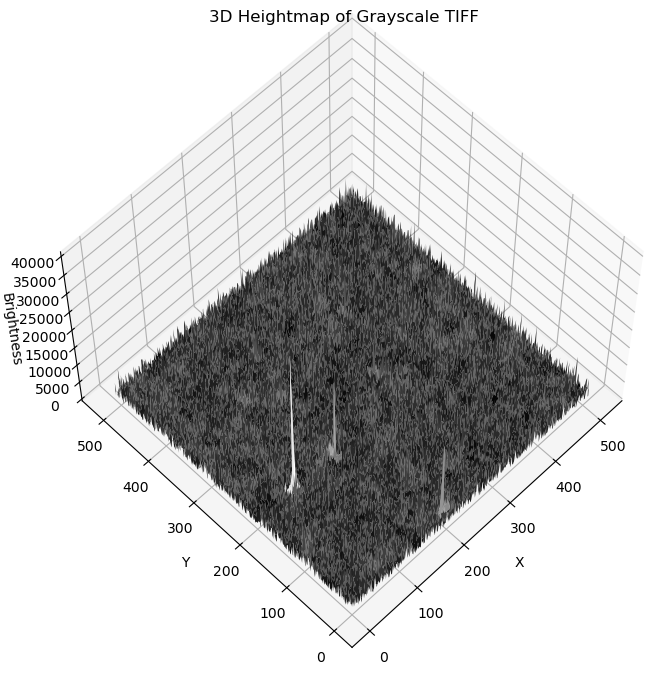

In [8]:
tif_path = os.path.join(output_dir, "simulation_v3.tif")
plot_tif(tif_path, frame=1)

In [9]:
## add functionality to do 3d plot video at some point

# Run TrackPy track making on Test data

See how the brightness estimate changes for a particle that stays for all frames

In [10]:
import pims
import trackpy as tp

# Load the TIFF sequence
frames = pims.open("test_NIST/test_from_NIST.tif")  # could also be "your_video.tif:0" to open from index 0

# Parameters: adjust `diameter` based on particle size, and `minmass` for brightness threshold
diameter = 11
minmass = 100

# Batch process: locate particles in all frames
f = tp.batch(frames, diameter=diameter, minmass=minmass)



Frame 0: 10444 features


In [11]:
# Search range (pixels per frame) should be slightly larger than expected maximum motion
linked = tp.link_df(f, search_range=5, memory=3)

In [12]:
# Filter tracks with more than 50 frames
long_tracks = tp.filter_stubs(linked, threshold=50)

C:\Users\brandon\AppData\Local\Temp\ipykernel_3604\2224591530.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


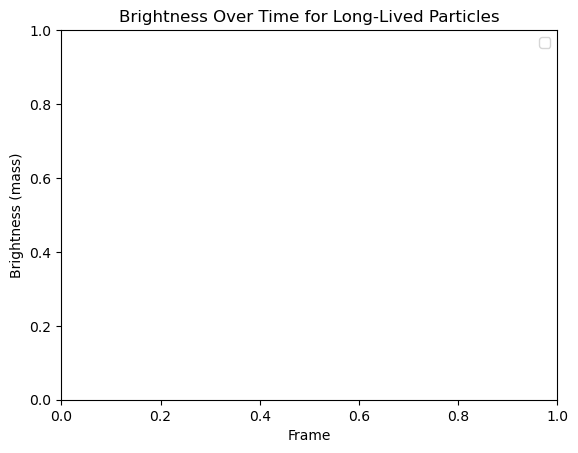

In [13]:
import matplotlib.pyplot as plt

# Group by particle ID
for particle, group in long_tracks.groupby('particle'):
    plt.plot(group['frame'], group['mass'], label=f'Particle {particle}')

plt.xlabel('Frame')
plt.ylabel('Brightness (mass)')
plt.title('Brightness Over Time for Long-Lived Particles')
plt.legend()
plt.show()

In [14]:
linked

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
10431,2042.158074,131.570832,193.842376,2.595687,0.209480,10.552305,11423.0,-0.296751,0,0
10430,2040.725125,9.841004,189.890082,3.221547,0.393886,8.688622,10642.0,-0.204055,0,1
10429,2042.575447,2027.922501,186.413348,2.793375,0.113800,10.783659,13214.0,7.110655,0,2
10428,2041.088183,1833.840722,253.101089,3.363476,0.271128,13.701288,14169.0,0.496897,0,3
10427,2040.407772,1652.423830,257.329723,3.313133,0.297019,12.043252,14104.0,0.530480,0,4
...,...,...,...,...,...,...,...,...,...,...
10440,2042.551196,1421.517562,336.285643,3.208902,0.293516,12.930108,14595.0,0.351189,0,10439
10441,2042.386927,1435.878429,336.150687,2.371745,0.183452,24.047945,14441.0,0.392831,0,10440
10442,2041.648200,1715.232328,246.738858,2.502804,0.179293,13.720567,14011.0,0.587268,0,10441
10443,2042.314806,1885.254235,224.188287,3.221074,0.368623,10.256686,13884.0,0.687819,0,10442


In [15]:
long_tracks

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,


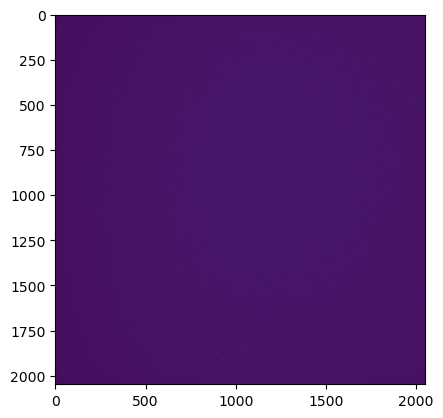

In [16]:
plt.imshow(frames[0]);

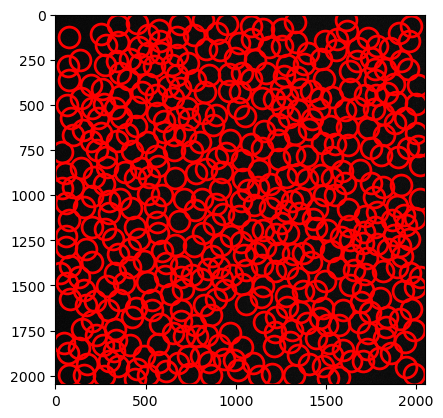

In [17]:
f = tp.locate(frames[0], 55, minmass=20)

tp.annotate(f, frames[0]);

In [18]:
print(f.shape)
f.head()

(459, 9)


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,31.508889,816.399594,7488.423405,16.055983,0.214890,73.104612,409089.0,NaN,0
1,30.522893,1612.367671,6275.342268,18.494516,0.124908,17.679203,418806.0,NaN,0
2,38.600418,1330.559473,5804.558372,18.642061,0.012523,18.058721,423917.0,NaN,0
3,50.155961,691.190308,5858.244324,18.506178,0.060577,16.611809,398621.0,NaN,0
4,50.821442,949.652406,6543.590178,16.346224,0.018396,49.028953,421867.0,NaN,0


C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

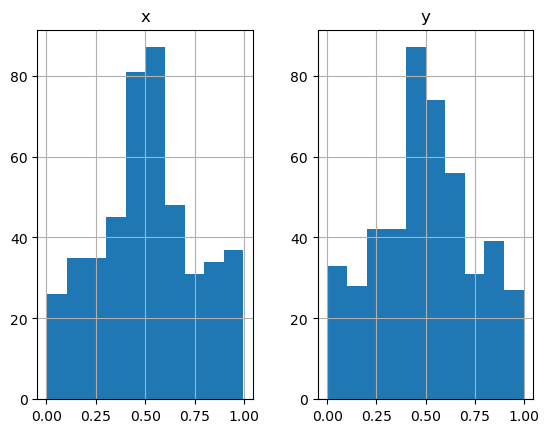

In [19]:
tp.subpx_bias(f)

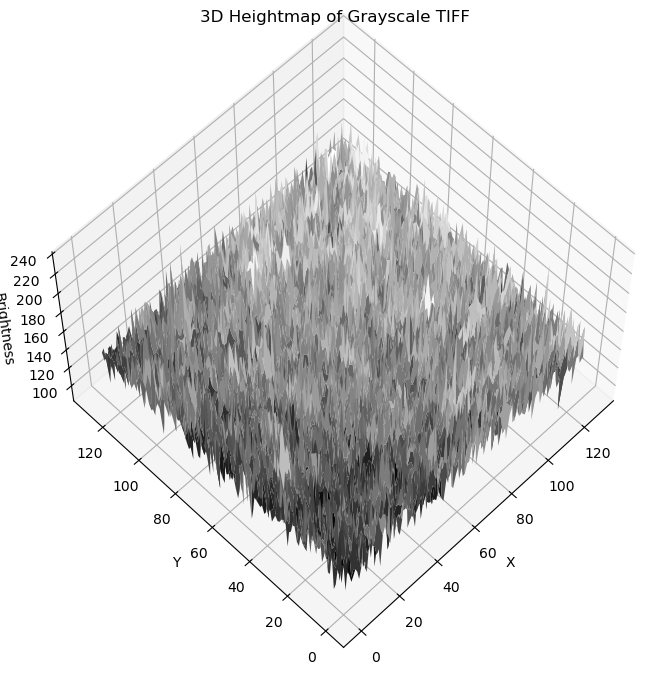

In [23]:
plot_tif("test_NIST/test_from_NIST.tif", frame=0, subset=[[0, 128], [0, 128]])

In [100]:
# Clipping function similar to what NIST provided
"""
Input:
 - frame (numpy array)
 - gamma = gamme for adjust_gamma
 - clip_quantile = 0.9999 (quantile to max clip to)

Return:
 - adjusted_frame (numpy array)

Also prints if image is low contrast
  
"""

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.exposure import adjust_gamma
from skimage.exposure import is_low_contrast


def adjust_frame(frame, gamma=0.5, clip_quantile=0.9999):
    tmp = frame.copy()
    tmp[tmp > np.quantile(tmp, clip_quantile)] = np.quantile(tmp, clip_quantile)
    print(tmp.dtype)
    tmp = adjust_gamma(tmp, gamma)
    print(np.max(tmp))
    print(is_low_contrast(tmp))

    return tmp


In [103]:
gamma=2
clip_quantile=0.9999
image = None

with tifffile.TiffFile("test_NIST/test_from_NIST.tif") as tif:
    image = tif.pages[0].asarray()

ps = [0, 25, 50, 75, 90, 95, 99, 99.999, 99.99999, 99.9999999]
# Compute percentile values
pre_percentile_values = np.percentile(image, ps)

tmp = image.copy()
tmp[tmp > np.quantile(tmp, clip_quantile)] = np.quantile(tmp, clip_quantile)

mid_percentile_values = np.percentile(tmp, ps)
print(tmp.dtype)

#tmp = adjust_gamma(tmp, gamma)
tmp = adjust_gamma(tmp, gamma)

print(tmp.dtype)

print(tmp)

adjusted_img = tmp.copy()

post_percentile_values = np.percentile(adjusted_img, ps)

adjusted_image_16bit = Image.fromarray(adjusted_img, mode="I;16")
# save in tif format
adjusted_image_16bit.save("test_NIST/frame_0_adjusted.tif", format="TIFF")


uint16
uint16
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [84]:
pre_percentile_values

array([  54.        ,  166.        ,  180.        ,  193.        ,
        204.        ,  211.        ,  224.        ,  359.05697   ,
       1851.63410112, 2445.00634108])

In [99]:
post_percentile_values

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [86]:
mid_percentile_values

array([ 54., 166., 180., 193., 204., 211., 224., 261., 261., 261.])

In [77]:
print(image.dtype)

uint16


In [58]:
adjusted_image.dtype

dtype('uint16')

In [88]:
img_info("test_NIST/frame_0_adjusted.tif", True)

Info for test_NIST/frame_0_adjusted.tif :
Size: (2048, 2048)
Mode: I;16
max pixel: 4135
min pixel: 1881
average pixel: 3422.449168920517
0th percentile: 1881.0
25th percentile: 3298.0
50th percentile: 3434.0
75th percentile: 3556.0
90th percentile: 3656.0
95th percentile: 3718.0
99th percentile: 3831.0
99.999th percentile: 4135.0
99.99999th percentile: 4135.0
99.9999999th percentile: 4135.0


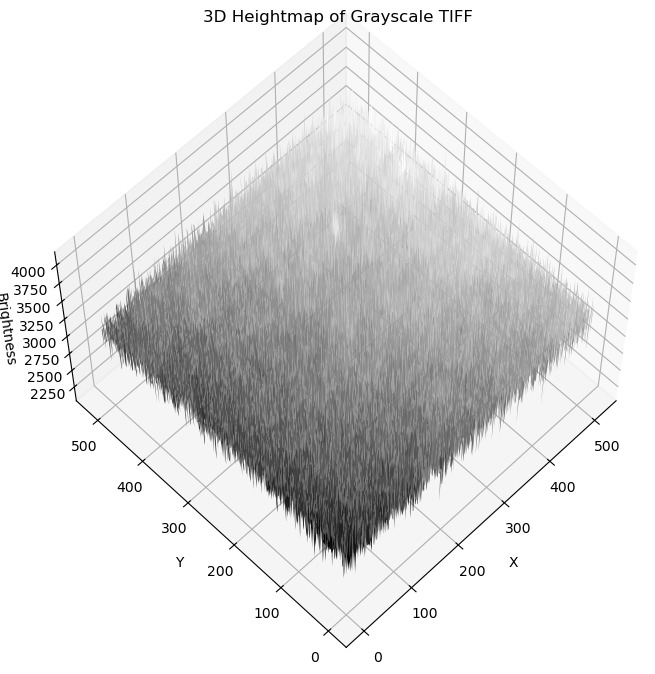

In [90]:
plot_tif("test_NIST/frame_0_adjusted.tif", subset=[[0,512],[0,512]])

In [59]:
img_info("test_NIST/1. Fluo_0.1s_mid_t010_ORG.tif", True)

Info for test_NIST/1. Fluo_0.1s_mid_t010_ORG.tif :
Size: (2048, 2048)
Mode: I;16
max pixel: 2451
min pixel: 54
average pixel: 179.3534677028656
0th percentile: 54.0
25th percentile: 166.0
50th percentile: 180.0
75th percentile: 193.0
90th percentile: 204.0
95th percentile: 211.0
99th percentile: 224.0
99.999th percentile: 359.05696999980137
99.99999th percentile: 1851.6341011174954
99.9999999th percentile: 2445.0063410843723
